In [1]:
library(tidyverse)
library(cowplot)
library(arrow)
library(yardstick)
library(ggridges)

── Attaching core tidyverse packages ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘cowplot’


The following object is masked from ‘package:lubridate’:

    stamp



Attaching package: ‘arrow’


The following object is masked from ‘package:lubridate’:

    duration


The following object is masked from ‘package:utils’:

    timestamp



Attaching packag

# How well do PCs fit the phenotypes?

In [2]:
pca_df <- read_tsv("data/pheno/pca.tsv", show_col_types = F)
pheno_df <- read_tsv("data/pheno/binary_pheno.tsv", show_col_types = F)

In [ ]:
coef_paths <- fs::dir_ls(path = "data/coef/", glob = "*pca_*tsv")

coef_paths

In [36]:
make_pheno_hat <- function(path) {
    read_tsv(path, show_col_types = F) %>%
    select(-feature) %>%
    as.matrix %>%
    {
        as.matrix(select(pca_df, starts_with("PC"))) %*% .
    } %>%
    as_tibble %>%
    bind_cols(select(pca_df, IID), .)
}

compute_fit_quality <- function(pheno_hat_df) {
    map2(select(pheno_df, -FID, -IID), select(pheno_hat_df, -IID), rsq_vec) %>%
    as_tibble %>%
    pivot_longer(everything(), names_to = "phenotype", values_to = "rsq")
}

In [ ]:
fit_quality_df <- coef_paths %>%
    map2(
        names(.),
        ~.x %>% 
        make_pheno_hat %>%
        compute_fit_quality %>%
        mutate(
            fraction = str_extract(.y, "(?<=pca_)[0-9\\.]+(?=\\.tsv)") %>% 
                as.double
        )
    ) %>%
    bind_rows

fit_quality_df %>% head(2)

In [48]:
fit_quality_df %>% write_parquet("plot_data/pca_fit_quality.parquet")

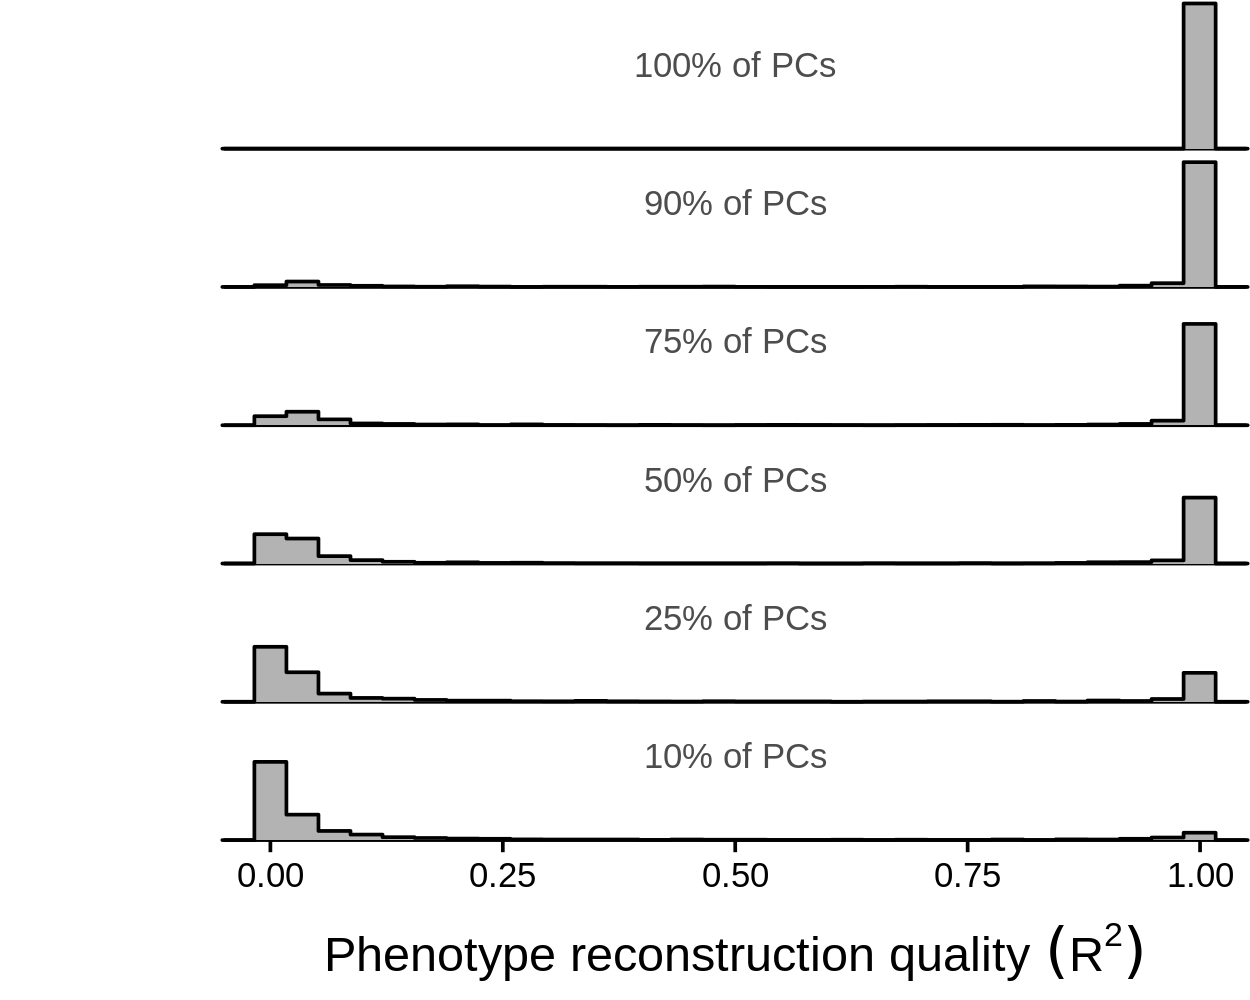

In [194]:
options(repr.plot.height = 4, repr.plot.width = 5, repr.plot.res = 250)

fit_quality_plot <- fit_quality_df %>%
    mutate(
        facet_label = as.integer(100 * fraction) %>% 
            as.character %>%
            str_c(., "% of PCs") %>%
            fct_reorder(fraction)
    ) %>%
    ggplot(aes(x = rsq, y = facet_label)) +
    geom_density_ridges(stat = "binline", bins = 30, scale = 1.05, linewidth = 0.5) +
    scale_y_discrete(expand = c(0, 0)) +
    coord_cartesian(clip = "off", xlim = c(0, 1)) +
    theme_ridges() +
    theme(
        axis.text.y = element_text(hjust = 0.5, vjust = -3, margin = margin(r = -182), color = "grey30", size = 10),
        plot.margin = margin(1, 1, 1, 182),
        axis.title.y = element_blank(),
        axis.ticks.y = element_blank(),
        
        panel.grid.major.x = element_blank(),
        panel.grid.major.y = element_line(linewidth = 0.5, color = "black"),
        axis.title.x = element_text(hjust = 0.5),
        axis.text.x = element_text(size = 10),
        axis.ticks.x = element_line(color = "black"),
    ) +
    xlab(expression("Phenotype reconstruction quality"~(R^2)))

fit_quality_plot

In [195]:
save_plot("img/pca_fit_quality.png", fit_quality_plot, base_height = 4, base_width = 5, dpi = 400)